# Machine Learning

In this file, instructions how to approach the challenge can be found.

We are going to work on different types of Machine Learning problems:

- **Regression Problem**: The goal is to predict delay of flights.
- **(Stretch) Multiclass Classification**: If the plane was delayed, we will predict what type of delay it is (will be).
- **(Stretch) Binary Classification**: The goal is to predict if the flight will be cancelled.

In [158]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## Main Task: Regression Problem

The target variable is **ARR_DELAY**. We need to be careful which columns to use and which don't. For example, DEP_DELAY is going to be the perfect predictor, but we can't use it because in real-life scenario, we want to predict the delay before the flight takes of --> We can use average delay from earlier days but not the one from the actual flight we predict.  

For example, variables **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY** shouldn't be used directly as predictors as well. However, we can create various transformations from earlier values.

We will be evaluating your models by predicting the ARR_DELAY for all flights **1 week in advance**.

## Feature Engineering for Regression Model

In [262]:
model_data = pd.read_csv("../../data/raw/random_sample_flight_data.csv")
model_data

,op_carrier_fl_num,op_unique_carrier,origin_airport_id,dest_airport_id,distance,route,month,day,fl_date,arr_delay
0,1610,UA,11618,13495,1167,11618-13495,3,1,2019-03-01,0.0
1,1519,UA,10800,11292,850,10800-11292,7,19,2019-07-19,-5.0
2,5452,OO,14487,14771,199,14487-14771,6,25,2018-06-25,119.0
3,1054,B6,14027,12478,1028,14027-12478,11,30,2018-11-30,3.0
4,790,UA,13930,10721,867,13930-10721,3,26,2019-03-26,-8.0
...,...,...,...,...,...,...,...,...,...,...
99995,6279,YV,12266,10994,925,12266-10994,7,31,2018-07-31,226.0
99996,2047,UA,12266,10721,1597,12266-10721,12,31,2018-12-31,-37.0
99997,7406,OO,11433,13459,349,11433-13459,7,22,2018-07-22,-22.0
99998,5151,OH,12323,11057,185,12323-11057,3,5,2019-03-05,109.0


In [263]:
def model_data_transformation(model_data):
    #call functions for data merging
    from add_location_weather import add_location
    
    #import datasets to merge with model data and do a little cleaning
    model_data['fl_date'] = model_data['fl_date'].astype('datetime64')
    airports_ids =  pd.read_csv("../../data/processed/Airports_lat_lon.csv")
    airports_ids = airports_ids.drop(['Unnamed: 0'], axis=1)
    weather_airports = pd.read_csv("../../data/processed/weatherAirports_2019_2018_Jan2020_clean.csv")
    weather_airports['fl_date'] = weather_airports['fl_date'].astype('datetime64')
    weather_airports = weather_airports.drop(['Unnamed: 0'], axis=1)
    
    #merge model data with airport ids and drop data that will be unnecesary to the model 
    df = add_location(model_data,airports_ids)
    df = df.drop(['airport_id','iata_code','lat','lon'], axis=1)
    
    #merge the flight & airport data with the weather data
    df1 = pd.merge(df,weather_airports, on = ['Key','fl_date'], how ='left')
    df1.drop_duplicates(inplace=True)
    
    # transform categorical variables in numeric with LabelEncoder
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()

    # fit and transform the data
    df1['op_unique_carrier'] = le.fit_transform(df1['op_unique_carrier'])
    df1['route'] = le.fit_transform(df1['route'])

    # drop rows with missing values
    df1 = df1.dropna().reset_index(drop=True)
    
    return(df1)

In [266]:
transformed_model_flight_df = model_data_transformation(model_data)
transformed_model_flight_df.to_csv('../../data/processed/transformed_model_flight_data.csv', index=False)

In [182]:
df = pd.read_csv('../../data/processed/transformed_model_flight_data.csv')
df

,op_carrier_fl_num,op_unique_carrier,origin_airport_id,dest_airport_id,distance,route,month,day,fl_date,arr_delay,Key,AvgTemp,Precipitation,Snow_mm,WindSpeed,lat,lon
0,1610,22,11618,13495,1167,1962,3,1,2019-03-01,0.0,40.692501-40.692501,0.8,1.3,30.0,15.9,40.692501,-74.168701
1,4909,6,11618,14524,277,1978,12,6,2019-12-06,-17.0,40.692501-40.692501,5.7,0.0,0.0,12.2,40.692501,-74.168701
2,3556,26,11618,11193,569,1928,4,3,2018-04-03,-9.0,40.692501-40.692501,4.9,5.8,30.0,11.1,40.692501,-74.168701
3,1382,2,11618,11298,1372,1932,9,7,2019-09-07,68.0,40.692501-40.692501,20.4,0.0,0.0,6.3,40.692501,-74.168701
4,3517,26,11618,13495,1167,1962,2,5,2018-02-05,-37.0,40.692501-40.692501,0.3,0.0,0.0,13.4,40.692501,-74.168701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97302,5026,19,11092,11292,283,1111,9,22,2019-09-22,0.0,38.75500107-38.75500107,16.0,0.0,0.0,0.0,38.755001,-109.754997
97303,5031,19,11092,11292,283,1111,8,10,2019-08-10,-12.0,38.75500107-38.75500107,27.3,0.0,0.0,0.0,38.755001,-109.754997
97304,5079,19,11092,11292,283,1111,8,15,2018-08-15,2.0,38.75500107-38.75500107,28.5,0.0,0.0,10.7,38.755001,-109.754997
97305,5031,19,11092,11292,283,1111,5,26,2019-05-26,-22.0,38.75500107-38.75500107,18.3,0.0,0.0,11.4,38.755001,-109.754997


In [161]:
df.columns.tolist()

['op_carrier_fl_num',
 'op_unique_carrier',
 'origin_airport_id',
 'dest_airport_id',
 'distance',
 'route',
 'month',
 'day',
 'fl_date',
 'arr_delay',
 'Key',
 'AvgTemp',
 'Precipitation',
 'Snow_mm',
 'WindSpeed',
 'lat',
 'lon']

In [188]:
X = df.drop(['op_unique_carrier','dest_airport_id','day','fl_date','Key','lat','lon','fl_date','arr_delay'], axis=1)
y = df['arr_delay']


                   op_carrier_fl_num  origin_airport_id  distance     route  \
op_carrier_fl_num           1.000000          -0.021725 -0.360852 -0.018616   
origin_airport_id          -0.021725           1.000000  0.065652  0.996187   
distance                   -0.360852           0.065652  1.000000  0.068845   
route                      -0.018616           0.996187  0.068845  1.000000   
month                       0.011208          -0.004020  0.001494 -0.003994   
AvgTemp                    -0.077079           0.011714  0.050612  0.011279   
Precipitation               0.000282          -0.037302 -0.009797 -0.037477   
Snow_mm                     0.010457          -0.008375 -0.015987 -0.008250   
WindSpeed                  -0.017120           0.004950  0.049889  0.013727   

                      month   AvgTemp  Precipitation   Snow_mm  WindSpeed  
op_carrier_fl_num  0.011208 -0.077079       0.000282  0.010457  -0.017120  
origin_airport_id -0.004020  0.011714      -0.037302 -0.0

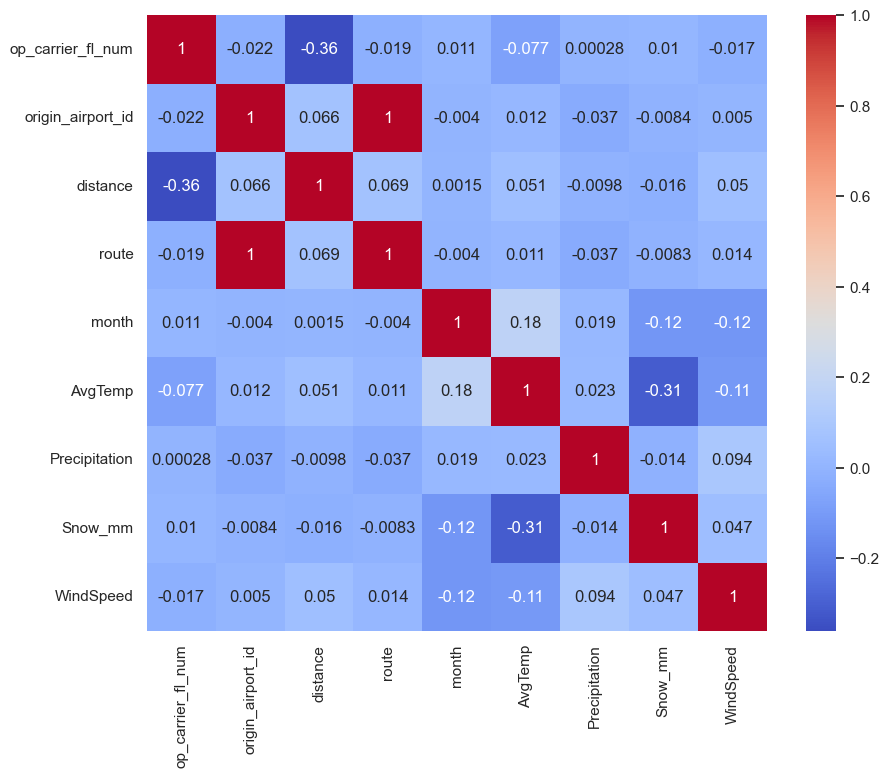

In [190]:
# Assuming your independent variables are stored in a pandas DataFrame called X
corr_matrix = X.corr()

# Print the correlation matrix
print(corr_matrix)

# Create a heatmap of the correlation matrix
#Set figure size to fit all variables
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Show the plot
plt.show()

## Linear Regression

In [193]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [194]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Scale the selected columns
X_scaled = scaler.fit_transform(X)

In [195]:
# split the data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [196]:
# train a linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [197]:
# evaluate the model on the testing dataset
y_pred = lr_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

Mean Squared Error: 2754.0127494322865


In [198]:
import math

# calculate RMSE using the square root function from the math module
rmse = math.sqrt(mse)
print("RMSE:", rmse)

RMSE: 52.47868852622259


In [201]:
from sklearn.metrics import r2_score

# Evaluate the model using R^2 score
score = r2_score(y_test, y_pred)
print("R^2 score for linear regression:", score)

R^2 score for linear regression: 0.014288168965429504


In [202]:
from sklearn.feature_selection import f_regression

# Get the number of features in the model
n_features = X_train.shape[1]
n_features

9

In [203]:
# Calculate the adjusted R-squared value
n_samples = X_train.shape[0]
adj_r_sq = 1 - (1 - r_sq) * (n_samples - 1) / (n_samples - n_features - 1)
adj_r_sq

0.014174191879551601

In [204]:
# Calculate the F-statistic and corresponding p-values for each feature
f_stats, p_values = f_regression(X_train, y_train)

#make a list of independent variable columns names
cols = X.columns.tolist()

# zip the array and list into a list of tuples
data = list(zip(cols, f_stats, p_values))

# create a DataFrame of the results
model_results = pd.DataFrame(data, columns=['Feature', 'F Stats', 'P Values'])
model_results


,Feature,F Stats,P Values
0,op_carrier_fl_num,41.769215,1.033122e-10
1,origin_airport_id,7.751790,5.367229e-03
2,distance,26.330764,2.883589e-07
3,route,7.108965,7.671522e-03
4,month,7.618926,5.777238e-03
5,AvgTemp,8.695341,3.191192e-03
6,Precipitation,698.708639,2.724787e-153
7,Snow_mm,45.781797,1.331174e-11
8,WindSpeed,65.685365,5.365736e-16


## Lasso & Ridge Regression

In [205]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV

In [73]:
# Define the parameter grid for the grid search
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Create a Ridge regression model object
ridge_model = Ridge()

# Create a Lasso regression model object
lasso_model = Lasso()

# Create a grid search object for Ridge regression
grid_search_ridge = GridSearchCV(ridge_model, param_grid, cv=5)

# Create a grid search object for Lasso regression
grid_search_lasso = GridSearchCV(lasso_model, param_grid, cv=5)

# Fit the Ridge grid search to the training data
grid_search_ridge.fit(X_train, y_train)

# Fit the Lasso grid search to the training data
grid_search_lasso.fit(X_train, y_train)

# Print the best parameters and score for Ridge regression
print("Best parameters for Ridge regression:", grid_search_ridge.best_params_)
print("Best score for Ridge regression:", grid_search_ridge.best_score_)

# Print the best parameters and score for Lasso regression
print("Best parameters for Lasso regression:", grid_search_lasso.best_params_)
print("Best score for Lasso regression:", grid_search_lasso.best_score_)

Best parameters for Ridge regression: {'alpha': 1000}
Best score for Ridge regression: 0.010731450070757643
Best parameters for Lasso regression: {'alpha': 0.01}
Best score for Lasso regression: 0.010720645082338253


In [206]:
# train a ridge regression model
ridge_model = Ridge(alpha=100) 
ridge_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = ridge_model.predict(X_test)

# Evaluate the model using R^2 score
score = r2_score(y_test, y_pred)
print("R^2 score for Ridge regression:", score)

R^2 score for Ridge regression: 0.014286026601158408


In [207]:
# evaluate the model on the testing dataset
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

Mean Squared Error: 2754.018735054383


In [208]:
import math

# calculate RMSE using the square root function from the math module
rmse = math.sqrt(mse)
print("RMSE:", rmse)

RMSE: 52.47874555526631


In [209]:
# train a lasso regression model
lasso_model = Lasso(alpha=0.01) 
lasso_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lasso_model.predict(X_test)

# Evaluate the model using R^2 score
score = r2_score(y_test, y_pred)
print("R^2 score for Lasso regression:", score)

R^2 score for Lasso regression: 0.014286052887941825


In [210]:
# evaluate the model on the testing dataset
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

Mean Squared Error: 2754.018661610873


In [211]:
import math

# calculate RMSE using the square root function from the math module
rmse = math.sqrt(mse)
print("RMSE:", rmse)

RMSE: 52.478744855521015


## Test Regression Model with Test Data

In [267]:
df_week_one  = pd.read_csv("../../data/raw/Week_one_data_10000.csv")
df_week_one

,op_carrier_fl_num,op_unique_carrier,origin_airport_id,dest_airport_id,distance,route,day
0,5390,WN,14057,11292,991.0,14057-11292,1
1,2331,WN,15376,11292,639.0,15376-11292,2
2,2321,NK,14843,11618,1608.0,14843-11618,5
3,5496,OO,11109,12266,809.0,11109-12266,3
4,2811,QX,11884,14057,279.0,11884-14057,3
...,...,...,...,...,...,...,...
9995,1447,DL,12953,10397,762.0,12953-10397,2
9996,167,NK,10821,14492,255.0,10821-14492,4
9997,1037,UA,11618,11298,1372.0,11618-11298,7
9998,6130,YX,14122,12953,335.0,14122-12953,3


In [268]:
def week_one_data_transformation(df_week_one):
    #call functions for data merging
    from add_location_weather import add_location
    from add_location_weather import add_weather
    
    #import datasets to merge with test data
    airports_ids =  pd.read_csv("../../data/processed/Airports_lat_lon.csv")
    airports_ids = airports_ids.drop(['Unnamed: 0'], axis=1)
    weather_airports = pd.read_csv("../../data/processed/weatherAirports_2019_2018_Jan2020_clean.csv")
    weather_airports = weather_airports.drop(['Unnamed: 0'], axis=1)
    
    #merge week one test data with airport ids and drop data that will be unnecesary to the model    
    df = add_location(df_week_one,airports_ids)
    df = df.drop(['airport_id','iata_code','lat','lon'], axis=1)
    
    #merge the flight & airport data with the weather data
    df1= add_weather(df,weather_airports)
    
    #get month data out of fl_date
    import datetime
    df1['Month'] = df1['fl_date'].dt.month
    
    # transform categorical variables in numeric with LabelEncoder
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()

    # fit and transform the data
    df1['op_unique_carrier'] = le.fit_transform(df1['op_unique_carrier'])
    df1['route'] = le.fit_transform(df1['route'])

    # drop rows with missing values
    df1 = df1.dropna().reset_index(drop=True)
    
    return(df1)

In [269]:
df_transformed_week1_2020 = week_one_data_transformation(df_week_one)
df_transformed_week1_2020.to_csv('../../data/processed/transformed_week1_2020.csv', index=False)

In [78]:
df1 = pd.read_csv('../../data/processed/transformed_week1_2020.csv')
df1

,op_carrier_fl_num,op_unique_carrier,origin_airport_id,dest_airport_id,distance,route,day,Key,fl_date,AvgTemp,Precipitation,Snow_mm,WindSpeed,lat,lon,Month
0,5390,21,14057,11292,991.0,2737,1,45.58869934-45.58869934,2020-01-01,10.8,3.8,0.0,11.9,45.588699,-122.598000,1
1,5752,6,14057,14747,129.0,2764,7,45.58869934-45.58869934,2020-01-07,11.3,2.8,0.0,24.8,45.588699,-122.598000,1
2,789,20,14057,11292,991.0,2737,2,45.58869934-45.58869934,2020-01-02,8.2,1.0,0.0,11.9,45.588699,-122.598000,1
3,1184,2,14057,14679,933.0,2763,7,45.58869934-45.58869934,2020-01-07,11.3,2.8,0.0,24.8,45.588699,-122.598000,1
4,1552,2,14057,14262,873.0,2760,7,45.58869934-45.58869934,2020-01-07,11.3,2.8,0.0,24.8,45.588699,-122.598000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9911,5147,17,14006,13930,342.0,2708,6,37.06079864501953-37.06079864501953,2020-01-06,5.3,0.0,0.0,7.9,37.060799,-88.773804,1
9912,5081,17,13121,13930,489.0,2064,2,37.8582992554-37.8582992554,2020-01-02,1.9,0.0,0.0,1.8,37.858299,-80.399498,1
9913,3845,14,11905,11298,140.0,1419,2,32.38399887084961-32.38399887084961,2020-01-02,12.1,4.6,0.0,11.9,32.383999,-94.711502,1
9914,4258,17,12003,14869,463.0,1466,6,47.48199844-47.48199844,2020-01-06,0.1,0.0,0.0,26.3,47.481998,-111.371002,1


In [79]:
df1.columns.tolist()

['op_carrier_fl_num',
 'op_unique_carrier',
 'origin_airport_id',
 'dest_airport_id',
 'distance',
 'route',
 'day',
 'Key',
 'fl_date',
 'AvgTemp',
 'Precipitation',
 'Snow_mm',
 'WindSpeed',
 'lat',
 'lon',
 'Month']

In [80]:
X_2020 = df1.drop(['op_unique_carrier','dest_airport_id','day','fl_date','Key','lat','fl_date'], axis=1)
X_2020.shape

(9916, 10)

In [81]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Scale the selected columns
X_2020_scaled = scaler.fit_transform(X_2020)

In [82]:
y_2020_pred = lr_model.predict(X_2020_scaled)
y_2020_pred.shape

(9916,)

In [83]:
X_2020['arr_delay'] = y_2020_pred
X_2020

,op_carrier_fl_num,origin_airport_id,distance,route,AvgTemp,Precipitation,Snow_mm,WindSpeed,lon,Month,arr_delay
0,5390,14057,991.0,2737,10.8,3.8,0.0,11.9,-122.598000,1,4.244054
1,5752,14057,129.0,2764,11.3,2.8,0.0,24.8,-122.598000,1,8.125746
2,789,14057,991.0,2737,8.2,1.0,0.0,11.9,-122.598000,1,1.322505
3,1184,14057,933.0,2763,11.3,2.8,0.0,24.8,-122.598000,1,4.862096
4,1552,14057,873.0,2760,11.3,2.8,0.0,24.8,-122.598000,1,5.115973
...,...,...,...,...,...,...,...,...,...,...,...
9911,5147,14006,342.0,2708,5.3,0.0,0.0,7.9,-88.773804,1,5.369864
9912,5081,13121,489.0,2064,1.9,0.0,0.0,1.8,-80.399498,1,4.559055
9913,3845,11905,140.0,1419,12.1,4.6,0.0,11.9,-94.711502,1,6.426901
9914,4258,12003,463.0,1466,0.1,0.0,0.0,26.3,-111.371002,1,8.732951


In [84]:
X_2020.sort_values(['arr_delay'], ascending = False).head(20)

,op_carrier_fl_num,origin_airport_id,distance,route,AvgTemp,Precipitation,Snow_mm,WindSpeed,lon,Month,arr_delay
9374,3617,11337,144.0,1130,-7.1,0.0,510.0,26.3,-92.193604,1,89.856296
9373,5150,11337,397.0,1131,-4.9,0.0,510.0,21.6,-92.193604,1,89.165381
9371,3685,11337,397.0,1131,-4.9,0.0,510.0,21.6,-92.193604,1,88.361202
9370,5186,11337,397.0,1131,-3.2,0.5,510.0,15.8,-92.193604,1,87.771495
9372,4025,11337,144.0,1130,-3.2,0.5,510.0,15.8,-92.193604,1,87.370185
9680,4600,11637,627.0,1313,-9.6,0.0,410.0,16.2,-96.815804,1,71.841739
9689,3654,11637,557.0,1315,-9.6,0.0,410.0,16.2,-96.815804,1,71.391123
9684,5203,11637,223.0,1314,-3.3,0.3,410.0,7.6,-96.815804,1,70.067835
9682,5203,11637,223.0,1314,-2.2,0.0,380.0,25.9,-96.815804,1,69.636606
9685,4183,11637,557.0,1315,-3.3,0.3,410.0,7.6,-96.815804,1,69.195904


In [85]:
X_2020.sort_values(['arr_delay']).head(20)

,op_carrier_fl_num,origin_airport_id,distance,route,AvgTemp,Precipitation,Snow_mm,WindSpeed,lon,Month,arr_delay
4416,344,12173,4817.0,1480,24.4,0.0,0.0,10.1,-157.924228,1,-6.169683
4380,448,12173,4983.0,1483,23.9,0.3,0.0,11.5,-157.924228,1,-5.825749
4434,218,12173,4243.0,1492,23.9,0.3,0.0,11.5,-157.924228,1,-5.244068
4451,8,12173,3784.0,1477,23.9,0.3,0.0,11.5,-157.924228,1,-4.950736
4397,102,12173,3784.0,1477,23.9,0.3,0.0,11.5,-157.924228,1,-4.899136
4453,201,12173,3801.0,1479,23.9,0.3,0.0,11.5,-157.924228,1,-4.857785
7531,596,13830,2935.0,2500,22.8,0.0,0.0,9.4,-156.431212,1,-4.624192
7519,42,13830,2338.0,2499,22.8,0.0,0.0,9.4,-156.431212,1,-4.369410
4420,383,12173,3365.0,1476,23.9,0.3,0.0,11.5,-157.924228,1,-4.353078
4395,362,12173,4962.0,1478,24.4,0.0,0.0,18.7,-157.924228,1,-4.241001


In [86]:
X_2020['arr_delay'].describe()

count    9916.000000
mean        5.596866
std         5.656718
min        -6.169683
25%         2.925321
50%         5.006636
75%         7.125096
max        89.856296
Name: arr_delay, dtype: float64

## XGBoost using XGBRegressor

In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score 
import warnings
warnings.filterwarnings("ignore")

In [231]:
df_xgboost = pd.read_csv('../../data/processed/transformed_model_flight_data.csv')
df_xgboost

,op_carrier_fl_num,op_unique_carrier,origin_airport_id,dest_airport_id,distance,route,month,day,fl_date,arr_delay,Key,AvgTemp,Precipitation,Snow_mm,WindSpeed,lat,lon
0,1610,22,11618,13495,1167,1962,3,1,2019-03-01,0.0,40.692501-40.692501,0.8,1.3,30.0,15.9,40.692501,-74.168701
1,4909,6,11618,14524,277,1978,12,6,2019-12-06,-17.0,40.692501-40.692501,5.7,0.0,0.0,12.2,40.692501,-74.168701
2,3556,26,11618,11193,569,1928,4,3,2018-04-03,-9.0,40.692501-40.692501,4.9,5.8,30.0,11.1,40.692501,-74.168701
3,1382,2,11618,11298,1372,1932,9,7,2019-09-07,68.0,40.692501-40.692501,20.4,0.0,0.0,6.3,40.692501,-74.168701
4,3517,26,11618,13495,1167,1962,2,5,2018-02-05,-37.0,40.692501-40.692501,0.3,0.0,0.0,13.4,40.692501,-74.168701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97302,5026,19,11092,11292,283,1111,9,22,2019-09-22,0.0,38.75500107-38.75500107,16.0,0.0,0.0,0.0,38.755001,-109.754997
97303,5031,19,11092,11292,283,1111,8,10,2019-08-10,-12.0,38.75500107-38.75500107,27.3,0.0,0.0,0.0,38.755001,-109.754997
97304,5079,19,11092,11292,283,1111,8,15,2018-08-15,2.0,38.75500107-38.75500107,28.5,0.0,0.0,10.7,38.755001,-109.754997
97305,5031,19,11092,11292,283,1111,5,26,2019-05-26,-22.0,38.75500107-38.75500107,18.3,0.0,0.0,11.4,38.755001,-109.754997


In [232]:
X = df_xgboost.drop(['op_unique_carrier','dest_airport_id','day','fl_date','Key','lat','lon','fl_date','arr_delay'], axis=1)
y = df_xgboost['arr_delay']

In [233]:
#Split dataset into training and test
seed = 8
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_size, random_state=seed)

In [234]:
#XGBoost hyper-parameter tuning
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror']
    }

    xgb_model = XGBRegressor()

    xsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           #scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    xsearch.fit(X_train,y_train)

    return xsearch.best_params_

In [235]:
#hyperParameterTuning(X_train, y_train)

In [236]:
#Initiate XGBoost object with best options after tuning

xreg_model = XGBRegressor(colsample_bytree = 0.5,
                            learning_rate = 0.01,
                            max_depth= 10,
                            min_child_weight= 5,
                            n_estimators= 200,
                            objective= 'reg:squarederror',
                            subsample= 0.7)

In [237]:
#fit model to train data
xreg_model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [238]:
pred_train = xreg_model.predict(X_train)

In [239]:
#Predict with test data
preds = xreg_model.predict(X_test)

In [240]:
#Test performance
rmse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)
train_score = xreg_model.score(X_train, y_train)
test_score  = xreg_model.score(X_test, y_test)

print(f"RMSE:  {rmse:.4f}")
print(f"R2: {r2:.4f}" )
print(f"Training Score: {train_score:.4f}" )
print(f"Test Score: {test_score:.4f}" )

RMSE:  2307.0628
R2: 0.0236
Training Score: 0.1305
Test Score: 0.0236


In [241]:
import pickle
pickle.dump(xreg_model, open('../../data/pickles/XBoostModel.pkl', 'wb'))

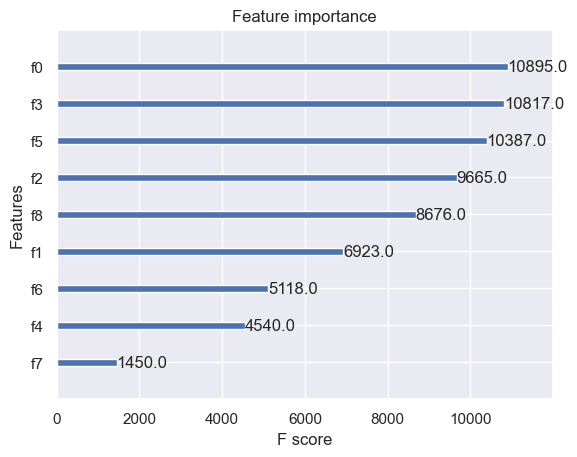

In [242]:
from xgboost import plot_importance

plot_importance(xreg_model)
plt.show()

In [243]:
print(xreg_model.feature_importances_)

[0.12256572 0.1032055  0.10662986 0.10607631 0.09066354 0.11215416
 0.17802964 0.08110534 0.09956986]


### Test XGBoost Regression Model with test data

In [245]:
# Import pickle
import pickle

# Load model from file
xgr_model = pickle.load(open('../../data/pickles/XBoostModel.pkl', "rb"))

# Import test data
df_txboost = pd.read_csv('../../data/processed/transformed_week1_2020.csv')
df_txboost.rename(columns={'Month': 'month'}, inplace=True) 
df_txboost

,op_carrier_fl_num,op_unique_carrier,origin_airport_id,dest_airport_id,distance,route,day,Key,fl_date,AvgTemp,Precipitation,Snow_mm,WindSpeed,lat,lon,month
0,5390,21,14057,11292,991.0,2737,1,45.58869934-45.58869934,2020-01-01,10.8,3.8,0.0,11.9,45.588699,-122.598000,1
1,5752,6,14057,14747,129.0,2764,7,45.58869934-45.58869934,2020-01-07,11.3,2.8,0.0,24.8,45.588699,-122.598000,1
2,789,20,14057,11292,991.0,2737,2,45.58869934-45.58869934,2020-01-02,8.2,1.0,0.0,11.9,45.588699,-122.598000,1
3,1184,2,14057,14679,933.0,2763,7,45.58869934-45.58869934,2020-01-07,11.3,2.8,0.0,24.8,45.588699,-122.598000,1
4,1552,2,14057,14262,873.0,2760,7,45.58869934-45.58869934,2020-01-07,11.3,2.8,0.0,24.8,45.588699,-122.598000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9911,5147,17,14006,13930,342.0,2708,6,37.06079864501953-37.06079864501953,2020-01-06,5.3,0.0,0.0,7.9,37.060799,-88.773804,1
9912,5081,17,13121,13930,489.0,2064,2,37.8582992554-37.8582992554,2020-01-02,1.9,0.0,0.0,1.8,37.858299,-80.399498,1
9913,3845,14,11905,11298,140.0,1419,2,32.38399887084961-32.38399887084961,2020-01-02,12.1,4.6,0.0,11.9,32.383999,-94.711502,1
9914,4258,17,12003,14869,463.0,1466,6,47.48199844-47.48199844,2020-01-06,0.1,0.0,0.0,26.3,47.481998,-111.371002,1


In [246]:
X_2020 = df_txboost.drop(['op_unique_carrier','dest_airport_id','day','fl_date','Key','lat','lon','fl_date'], axis=1)
X_2020 = df_txboost[['op_carrier_fl_num','origin_airport_id','distance','route','month','AvgTemp','Precipitation', 'Snow_mm', 'WindSpeed']]
X_2020

,op_carrier_fl_num,origin_airport_id,distance,route,month,AvgTemp,Precipitation,Snow_mm,WindSpeed
0,5390,14057,991.0,2737,1,10.8,3.8,0.0,11.9
1,5752,14057,129.0,2764,1,11.3,2.8,0.0,24.8
2,789,14057,991.0,2737,1,8.2,1.0,0.0,11.9
3,1184,14057,933.0,2763,1,11.3,2.8,0.0,24.8
4,1552,14057,873.0,2760,1,11.3,2.8,0.0,24.8
...,...,...,...,...,...,...,...,...,...
9911,5147,14006,342.0,2708,1,5.3,0.0,0.0,7.9
9912,5081,13121,489.0,2064,1,1.9,0.0,0.0,1.8
9913,3845,11905,140.0,1419,1,12.1,4.6,0.0,11.9
9914,4258,12003,463.0,1466,1,0.1,0.0,0.0,26.3


In [247]:
# make predictions for test data
y_2020_pred = xgr_model.predict(X_2020)

In [248]:
X_2020['arr_delay'] = y_2020_pred
X_2020

,op_carrier_fl_num,origin_airport_id,distance,route,month,AvgTemp,Precipitation,Snow_mm,WindSpeed,arr_delay
0,5390,14057,991.0,2737,1,10.8,3.8,0.0,11.9,88.615707
1,5752,14057,129.0,2764,1,11.3,2.8,0.0,24.8,81.576683
2,789,14057,991.0,2737,1,8.2,1.0,0.0,11.9,91.907974
3,1184,14057,933.0,2763,1,11.3,2.8,0.0,24.8,81.576683
4,1552,14057,873.0,2760,1,11.3,2.8,0.0,24.8,81.576683
...,...,...,...,...,...,...,...,...,...,...
9911,5147,14006,342.0,2708,1,5.3,0.0,0.0,7.9,87.931023
9912,5081,13121,489.0,2064,1,1.9,0.0,0.0,1.8,86.662468
9913,3845,11905,140.0,1419,1,12.1,4.6,0.0,11.9,92.253105
9914,4258,12003,463.0,1466,1,0.1,0.0,0.0,26.3,64.342278


In [249]:
X_2020.describe()

,op_carrier_fl_num,origin_airport_id,distance,route,month,AvgTemp,Precipitation,Snow_mm,WindSpeed,arr_delay
count,9916.000000,9916.000000,9916.000000,9916.000000,9916.0,9916.000000,9916.000000,9916.000000,9916.000000,9916.000000
mean,2808.134429,12713.165288,798.813836,1858.248689,1.0,8.349284,1.789391,5.164381,12.604871,87.846924
std,1867.691692,1510.815051,600.656478,1057.725199,0.0,6.632898,5.770032,29.983744,6.364357,8.183515
min,1.000000,10135.000000,31.000000,0.000000,1.0,-36.100000,0.000000,0.000000,0.000000,24.964878
25%,1179.000000,11292.000000,356.000000,950.000000,1.0,3.600000,0.000000,0.000000,7.800000,87.931023
50%,2420.000000,12892.000000,633.500000,1895.500000,1.0,7.900000,0.000000,0.000000,11.500000,87.931023
75%,4460.500000,14057.000000,1044.000000,2760.000000,1.0,12.500000,0.300000,0.000000,16.900000,87.931023
max,6796.000000,16101.000000,4983.000000,3713.000000,1.0,27.400000,105.400000,510.000000,41.000000,124.530708


In [250]:
X_2020['arr_delay'].describe()

count    9916.000000
mean       87.846924
std         8.183515
min        24.964878
25%        87.931023
50%        87.931023
75%        87.931023
max       124.530708
Name: arr_delay, dtype: float64

### XGBoost with k-fold cross validation

In [252]:
# Create regression matrices
data_dmatrix = xgb.DMatrix(data=X,label=y)
#dtest_dmatrix  = xgb.DMatrix(data=X_test,label=y_test)

In [257]:
# k-fold cross validation using xgboost

# Define parameters
params = {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 5,  'objective': 'reg:squarederror', 'subsample': 0.7}
#params = {'objective':"reg:squarederror", 'learning_rate': '0.01', 'colsample_bytree':'0.3', 'max_depth': 10}
xg_CV = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=105)

In [258]:
#Show results for each folder
xg_CV.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,51.690366,0.857776,51.592550,3.576830
1,51.662743,0.859421,51.581213,3.576513
2,51.633555,0.859305,51.569641,3.575651
3,51.603964,0.856501,51.558410,3.578748
4,51.575365,0.858208,51.547557,3.578596


In [259]:
#Show best RMSE
best_rmse = xg_CV['test-rmse-mean'].min()
best_rmse

51.19838035254391

In [260]:
import pickle
pickle.dump(xg_CV, open('../../data/pickles/XGBoostKfolders.pkl', 'wb'))

## Classifion Model

### Feature Engineering

In [290]:
df2 = pd.read_csv('../../data/processed/transformed_model_flight_data.csv')
df2

,op_carrier_fl_num,op_unique_carrier,origin_airport_id,dest_airport_id,distance,route,month,day,fl_date,arr_delay,Key,AvgTemp,Precipitation,Snow_mm,WindSpeed,lat,lon
0,1610,22,11618,13495,1167,1962,3,1,2019-03-01,0.0,40.692501-40.692501,0.8,1.3,30.0,15.9,40.692501,-74.168701
1,4909,6,11618,14524,277,1978,12,6,2019-12-06,-17.0,40.692501-40.692501,5.7,0.0,0.0,12.2,40.692501,-74.168701
2,3556,26,11618,11193,569,1928,4,3,2018-04-03,-9.0,40.692501-40.692501,4.9,5.8,30.0,11.1,40.692501,-74.168701
3,1382,2,11618,11298,1372,1932,9,7,2019-09-07,68.0,40.692501-40.692501,20.4,0.0,0.0,6.3,40.692501,-74.168701
4,3517,26,11618,13495,1167,1962,2,5,2018-02-05,-37.0,40.692501-40.692501,0.3,0.0,0.0,13.4,40.692501,-74.168701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97302,5026,19,11092,11292,283,1111,9,22,2019-09-22,0.0,38.75500107-38.75500107,16.0,0.0,0.0,0.0,38.755001,-109.754997
97303,5031,19,11092,11292,283,1111,8,10,2019-08-10,-12.0,38.75500107-38.75500107,27.3,0.0,0.0,0.0,38.755001,-109.754997
97304,5079,19,11092,11292,283,1111,8,15,2018-08-15,2.0,38.75500107-38.75500107,28.5,0.0,0.0,10.7,38.755001,-109.754997
97305,5031,19,11092,11292,283,1111,5,26,2019-05-26,-22.0,38.75500107-38.75500107,18.3,0.0,0.0,11.4,38.755001,-109.754997


In [291]:
df2['distance'].describe()

count    97307.000000
mean       769.625371
std        587.830448
min         16.000000
25%        341.000000
50%        603.000000
75%       1005.000000
max       5095.000000
Name: distance, dtype: float64

In [292]:
conditions = [
    (df2['distance']<=350),
    (df2['distance']>350) & (df2['distance']<1000),
    (df2['distance']>= 1000)]
choices = ['1.short', '2.medium', '3.long']
df2['flight_dist'] = np.select(conditions, choices)

# transform categorical variables in numeric with LabelEncoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# fit and transform the data
df2['flight_dist'] = le.fit_transform(df2['flight_dist'])
df2


,op_carrier_fl_num,op_unique_carrier,origin_airport_id,dest_airport_id,distance,route,month,day,fl_date,arr_delay,Key,AvgTemp,Precipitation,Snow_mm,WindSpeed,lat,lon,flight_dist
0,1610,22,11618,13495,1167,1962,3,1,2019-03-01,0.0,40.692501-40.692501,0.8,1.3,30.0,15.9,40.692501,-74.168701,2
1,4909,6,11618,14524,277,1978,12,6,2019-12-06,-17.0,40.692501-40.692501,5.7,0.0,0.0,12.2,40.692501,-74.168701,0
2,3556,26,11618,11193,569,1928,4,3,2018-04-03,-9.0,40.692501-40.692501,4.9,5.8,30.0,11.1,40.692501,-74.168701,1
3,1382,2,11618,11298,1372,1932,9,7,2019-09-07,68.0,40.692501-40.692501,20.4,0.0,0.0,6.3,40.692501,-74.168701,2
4,3517,26,11618,13495,1167,1962,2,5,2018-02-05,-37.0,40.692501-40.692501,0.3,0.0,0.0,13.4,40.692501,-74.168701,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97302,5026,19,11092,11292,283,1111,9,22,2019-09-22,0.0,38.75500107-38.75500107,16.0,0.0,0.0,0.0,38.755001,-109.754997,0
97303,5031,19,11092,11292,283,1111,8,10,2019-08-10,-12.0,38.75500107-38.75500107,27.3,0.0,0.0,0.0,38.755001,-109.754997,0
97304,5079,19,11092,11292,283,1111,8,15,2018-08-15,2.0,38.75500107-38.75500107,28.5,0.0,0.0,10.7,38.755001,-109.754997,0
97305,5031,19,11092,11292,283,1111,5,26,2019-05-26,-22.0,38.75500107-38.75500107,18.3,0.0,0.0,11.4,38.755001,-109.754997,0


In [293]:
df2.columns.tolist()

['op_carrier_fl_num',
 'op_unique_carrier',
 'origin_airport_id',
 'dest_airport_id',
 'distance',
 'route',
 'month',
 'day',
 'fl_date',
 'arr_delay',
 'Key',
 'AvgTemp',
 'Precipitation',
 'Snow_mm',
 'WindSpeed',
 'lat',
 'lon',
 'flight_dist']

In [294]:
df2 = df2.drop(['op_carrier_fl_num',
 'origin_airport_id',
 'dest_airport_id',
 'distance',
 'route',
 'day',
 'fl_date',
 'Key',
 'AvgTemp',
 'Precipitation',
 'Snow_mm',
 'WindSpeed',
 'lat',
 'lon'],axis=1)
df2

,op_unique_carrier,month,arr_delay,flight_dist
0,22,3,0.0,2
1,6,12,-17.0,0
2,26,4,-9.0,1
3,2,9,68.0,2
4,26,2,-37.0,2
...,...,...,...,...
97302,19,9,0.0,0
97303,19,8,-12.0,0
97304,19,8,2.0,0
97305,19,5,-22.0,0


### Random Forest Classifier

In [96]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize the random forest with optimized hyper parameters
rfc = RandomForestClassifier(n_estimators=200, max_depth=5, 
                             min_samples_split=10, min_samples_leaf=4, random_state=42)

In [174]:
y = y[0:15000]

In [172]:
X.columns.tolist()

['op_carrier_fl_num',
 'origin_airport_id',
 'distance',
 'route',
 'month',
 'AvgTemp',
 'Precipitation',
 'Snow_mm',
 'WindSpeed',
 'lon']

In [173]:
X = X.drop(['origin_airport_id','lon'], axis=1)

In [175]:
X = X[0:15000]

In [176]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Scale the selected columns
X_scaled = scaler.fit_transform(X)

In [177]:
# Split your data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [12]:
# Define the hyperparameters and their possible values
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [103]:
# Fit the classifier to the training data
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=4, min_samples_split=10,
                       n_estimators=200, random_state=42)

In [104]:
# # Create a GridSearchCV object and fit it to the training data
# grid_search = GridSearchCV(rfc, param_grid=param_grid, cv=5)
# grid_search.fit(X_train, y_train)

# # Print the best hyperparameters and the corresponding accuracy score
# print("Best hyperparameters: ", grid_search.best_params_)
# print("Best accuracy score: {:.2f}%".format(grid_search.best_score_ * 100))

In [105]:
# Predict the labels of the test data
y_pred = rfc.predict(X_test)

In [106]:
# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 score: {:.2f}%".format(f1 * 100))

Accuracy: 2.53%
Precision: 0.23%
Recall: 0.46%
F1 score: 0.18%


C:\Users\joshl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Random Forest Regressor

In [178]:
from sklearn.ensemble import RandomForestRegressor

# assuming you have your training data and labels stored in X_train and y_train
# create a Random Forest Regressor object
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# fit the regressor to the training data
rf_regressor.fit(X_train, y_train)

# assuming you have your test data stored in X_test
# use the regressor to predict the labels of the test data
y_pred = rf_regressor.predict(X_test)

In [180]:
# evaluate the model on the testing dataset
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

Mean Squared Error: 2210.5927759666665


In [181]:
import math

# calculate RMSE using the square root function from the math module
rmse = math.sqrt(mse)
print("RMSE:", rmse)

RMSE: 47.016941371878566


## Test Random Forest

In [108]:
# X_2020 = X_2020.drop(['origin_airport_id','lon'], axis=1)
X_2020 = X_2020.drop(['arr_delay'], axis=1)
X_2020.shape

(9916, 8)

In [109]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Scale the selected columns
X_scaled = scaler.fit_transform(X_2020)

In [110]:
# Predict the labels of the test data
y_2020_pred = rfc.predict(X_scaled)

In [111]:
X_2020['arr_delay'] = y_2020_pred
X_2020

,op_carrier_fl_num,distance,route,AvgTemp,Precipitation,Snow_mm,WindSpeed,Month,arr_delay
0,5390,991.0,2737,10.8,3.8,0.0,11.9,1,-12.0
1,5752,129.0,2764,11.3,2.8,0.0,24.8,1,-9.0
2,789,991.0,2737,8.2,1.0,0.0,11.9,1,-8.0
3,1184,933.0,2763,11.3,2.8,0.0,24.8,1,-8.0
4,1552,873.0,2760,11.3,2.8,0.0,24.8,1,-13.0
...,...,...,...,...,...,...,...,...,...
9911,5147,342.0,2708,5.3,0.0,0.0,7.9,1,-9.0
9912,5081,489.0,2064,1.9,0.0,0.0,1.8,1,-9.0
9913,3845,140.0,1419,12.1,4.6,0.0,11.9,1,-9.0
9914,4258,463.0,1466,0.1,0.0,0.0,26.3,1,-13.0


In [112]:
X_2020['arr_delay'].describe()

count    9916.000000
mean      -10.427289
std         3.524893
min       -27.000000
25%       -12.000000
50%        -9.000000
75%        -8.000000
max         3.000000
Name: arr_delay, dtype: float64

In [87]:
X_2020.value_counts(['arr_delay'])

arr_delay
-9.0         2890
-8.0         2829
-12.0        2617
-10.0         408
-14.0         299
-6.0          274
-2.0          241
-16.0          64
-11.0          56
-18.0          40
-20.0          40
-17.0          40
-7.0           38
 1.0           24
-5.0           15
-13.0          14
-1.0           10
 0.0            6
-15.0           3
-4.0            3
 3.0            3
-3.0            2
dtype: int64

In [88]:
X_2020.sort_values(['arr_delay'], ascending = False).head(20)

,op_carrier_fl_num,distance,AvgTemp,Precipitation,Snow_mm,WindSpeed,lon,Month,arr_delay
5733,2890,2585.0,11.1,0.0,0.0,5.8,-122.375000,1,3.0
5785,2936,2586.0,11.1,0.0,0.0,5.8,-122.375000,1,3.0
5744,2890,2585.0,10.3,0.0,0.0,5.8,-122.375000,1,3.0
8976,81,1413.0,0.5,0.0,0.0,4.7,-89.693298,1,1.0
7733,62,1035.0,19.2,0.0,0.0,8.3,-80.095596,1,1.0
3060,90,2422.0,5.2,0.0,0.0,34.6,-73.779317,1,1.0
7216,19,2554.0,15.8,0.0,0.0,7.8,-81.308998,1,1.0
1829,1,2329.0,7.7,0.0,0.0,13.0,-77.037697,1,1.0
7743,62,1035.0,26.3,0.8,0.0,21.2,-80.095596,1,1.0
7755,22,1197.0,18.1,0.0,0.0,23.8,-80.095596,1,1.0


In [89]:
X_2020.sort_values(['arr_delay']).head(20)

,op_carrier_fl_num,distance,AvgTemp,Precipitation,Snow_mm,WindSpeed,lon,Month,arr_delay
1283,28,2475.0,18.9,0.0,0.0,12.6,-118.407997,1,-20.0
5537,31,2695.0,9.3,0.0,0.0,5.0,-115.151817,1,-20.0
5554,8,2173.0,9.7,0.0,0.0,5.8,-115.151817,1,-20.0
812,10,2717.0,10.6,0.0,0.0,23.0,-122.311134,1,-20.0
1026,10,2475.0,16.3,0.0,0.0,9.0,-118.407997,1,-20.0
809,27,2677.0,8.3,2.5,0.0,22.7,-122.311134,1,-20.0
1708,59,2404.0,7.4,0.0,0.0,8.7,-121.591003,1,-20.0
9744,48,1843.0,-5.4,6.6,0.0,8.4,-107.218002,1,-20.0
1007,42,2402.0,14.4,0.0,0.0,7.6,-118.407997,1,-20.0
47,25,2603.0,10.8,3.8,0.0,11.9,-122.598000,1,-20.0


## Naive Bayes

In [113]:
from sklearn.naive_bayes import GaussianNB

In [114]:
#perform Naive Bayes
# Create a Gaussian Naive Bayes model
gnb = GaussianNB()

# Train the model using the training data
gnb.fit(X_train, y_train)

# Predict the target values for the testing data
y_pred = gnb.predict(X_test)

# Compute the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)


In [115]:
# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 score: {:.2f}%".format(f1 * 100))

Accuracy: 0.17%
Precision: 0.08%
Recall: 0.93%
F1 score: 0.05%


C:\Users\joshl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\joshl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## SVM

In [17]:
from sklearn.svm import SVC

In [116]:
# Create an SVM classifier
svm = SVC(kernel='linear')

# Train the classifier using the training data
svm.fit(X_train, y_train)

# Predict the target values for the testing data
y_pred = svm.predict(X_test)

In [117]:
# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 score: {:.2f}%".format(f1 * 100))

Accuracy: 2.33%
Precision: 0.05%
Recall: 0.41%
F1 score: 0.07%


C:\Users\joshl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\joshl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Feature Engineering

Feature engineering will play a crucial role in this problems. We have only very little attributes so we need to create some features that will have some predictive power.

- weather: we can use some weather API to look for the weather in time of the scheduled departure and scheduled arrival.
- statistics (avg, mean, median, std, min, max...): we can take a look at previous delays and compute descriptive statistics
- airports encoding: we need to think about what to do with the airports and other categorical variables
- time of the day: the delay probably depends on the airport traffic which varies during the day.
- airport traffic
- unsupervised learning as feature engineering?
- **what are the additional options?**: Think about what we could do more to improve the model.

### Feature Selection / Dimensionality Reduction

We need to apply different selection techniques to find out which one will be the best for our problems.

- Original Features vs. PCA conponents?

In [139]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [142]:
df = pd.read_csv('../../data/processed/transformed_model_flight_data.csv')

X = df.drop(['op_unique_carrier','dest_airport_id','day','fl_date','Key','lat','fl_date','arr_delay'], axis=1)
X = X.drop(['origin_airport_id','lon'], axis=1)

X_scaled = StandardScaler().fit_transform(X)

y = df['arr_delay']

In [143]:
pca = PCA(n_components=2) 
pca_features = pca.fit_transform(X_scaled)

print('Shape before PCA: ', X_scaled.shape)
print('Shape after PCA: ', pca_features.shape)

Shape before PCA:  (97307, 8)
Shape after PCA:  (97307, 2)


In [144]:
pca_df = pd.DataFrame(
    data=pca_features, 
    columns=['PC1', 'PC2'])
pca_df

,PC1,PC2
0,1.528231,1.555539
1,0.521969,-1.622080
2,1.596947,-0.082797
3,-1.350265,0.387553
4,1.368034,0.686511
...,...,...
97302,-0.169138,-2.251031
97303,-0.725113,-2.365870
97304,-0.374260,-1.896853
97305,0.594139,-1.448180


## Modelling with PCA Transformed Variables

In [151]:
y = y[0:15000]

In [152]:
pca_df = pca_df[0:15000]

In [153]:
# Split your data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(pca_df, y, test_size=0.2, random_state=42)

### Gaussian Naive Bayes

In [154]:
# Create a Gaussian Naive Bayes model
gnb = GaussianNB()

# Train the model using the training data
gnb.fit(X_train, y_train)

# Predict the target values for the testing data
y_pred = gnb.predict(X_test)

In [155]:
# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 score: {:.2f}%".format(f1 * 100))

Accuracy: 2.53%
Precision: 0.09%
Recall: 0.46%
F1 score: 0.12%


C:\Users\joshl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\joshl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### SVM Classifier

In [131]:
# Create an SVM classifier
svm = SVC(kernel='linear')

# Train the classifier using the training data
svm.fit(X_train, y_train)

# Predict the target values for the testing data
y_pred = svm.predict(X_test)

In [132]:
# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 score: {:.2f}%".format(f1 * 100))

Accuracy: 2.60%
Precision: 0.08%
Recall: 0.49%
F1 score: 0.07%


C:\Users\joshl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Random Forest Classifier

In [156]:
# Create a Random Forest classifier
rfc = RandomForestClassifier(n_estimators=200, max_depth=5, 
                             min_samples_split=10, min_samples_leaf=4, random_state=42)

# Train the classifier using the training data
rfc.fit(X_train, y_train)

# Predict the target values for the testing data
y_pred = rfc.predict(X_test)

In [157]:
# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 score: {:.2f}%".format(f1 * 100))

Accuracy: 2.97%
Precision: 0.20%
Recall: 0.53%
F1 score: 0.19%


C:\Users\joshl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## PCA Plots

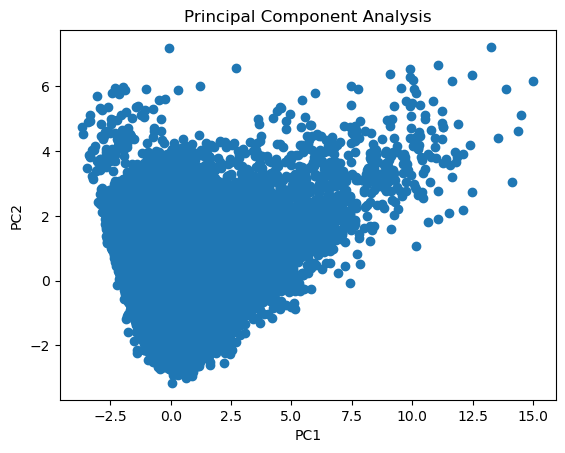

In [145]:
plt.scatter(pca_df['PC1'], pca_df['PC2'])
plt.title('Principal Component Analysis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [146]:
# Principal components correlation coefficients
loadings = pca.components_
 
# Number of features before PCA
n_features = pca.n_features_

# Feature names before PCA
feature_names = X.columns.values.tolist()

# PC names
pc_list = [f'PC{i}' for i in list(range(1, n_features + 1))]

# Match PC names to loadings
pc_loadings = dict(zip(pc_list, loadings))

# Matrix of corr coefs between feature names and PCs
loadings_df = pd.DataFrame.from_dict(pc_loadings)
loadings_df['feature_names'] = feature_names
loadings_df = loadings_df.set_index('feature_names')
loadings_df

,PC1,PC2
feature_names,,
op_carrier_fl_num,0.304223,-0.603533
distance,-0.289729,0.626495
route,-0.064924,0.150836
month,-0.388749,-0.259350
AvgTemp,-0.594402,-0.167862
Precipitation,-0.002403,0.007305
Snow_mm,0.511191,0.213470
WindSpeed,0.231363,0.281849


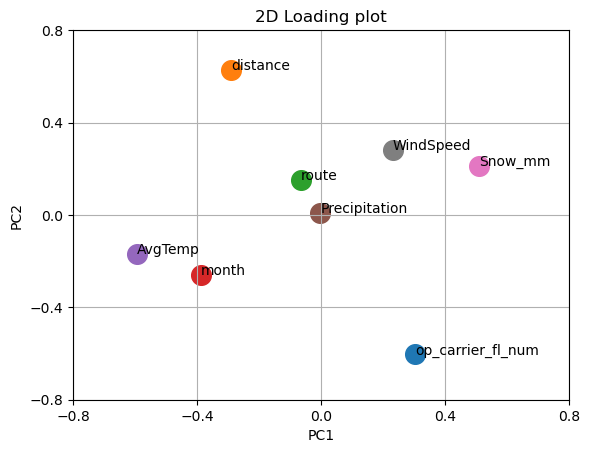

In [147]:
# Get the loadings of x and y axes
xs = loadings[0]
ys = loadings[1]
 
# Plot the loadings on a scatterplot
for i, varnames in enumerate(feature_names):
    plt.scatter(xs[i], ys[i], s=200)
    plt.text(xs[i], ys[i], varnames)
 
# Define the axes
xticks = np.linspace(-0.8, 0.8, num=5)
yticks = np.linspace(-0.8, 0.8, num=5)
plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid()

# Show plot
plt.title('2D Loading plot')
plt.show()

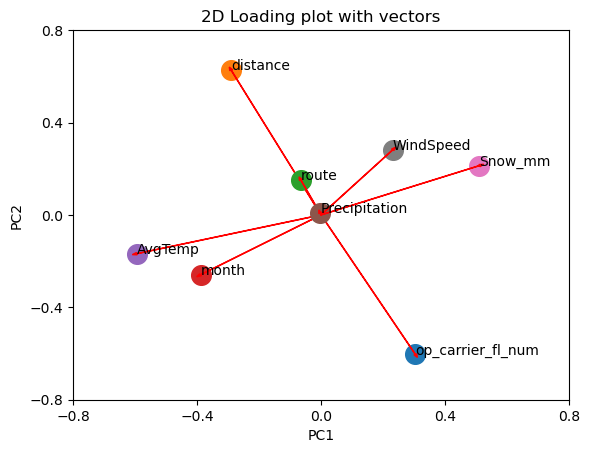

In [148]:
# Get the loadings of x and y axes
xs = loadings[0]
ys = loadings[1]
 
# Plot the loadings on a scatterplot
for i, varnames in enumerate(feature_names):
    plt.scatter(xs[i], ys[i], s=200)
    plt.arrow(
        0, 0, # coordinates of arrow base
        xs[i], # length of the arrow along x
        ys[i], # length of the arrow along y
        color='r', 
        head_width=0.01
        )
    plt.text(xs[i], ys[i], varnames)
 
# Define the axes
xticks = np.linspace(-0.8, 0.8, num=5)
yticks = np.linspace(-0.8, 0.8, num=5)
plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('PC1')
plt.ylabel('PC2')
 
# Show plot
plt.title('2D Loading plot with vectors')
plt.show()

In [149]:
pca_df_scaled = pca_df.copy()
 
scaler_df = pca_df[['PC1', 'PC2']]
scaler = 1 / (scaler_df.max() - scaler_df.min())
 
for index in scaler.index:
    pca_df_scaled[index] *= scaler[index]

pca_df_scaled

,PC1,PC2
0,0.081805,0.149850
1,0.027941,-0.156260
2,0.085483,-0.007976
3,-0.072279,0.037334
4,0.073230,0.066134
...,...,...
97302,-0.009054,-0.216848
97303,-0.038815,-0.227911
97304,-0.020034,-0.182729
97305,0.031804,-0.139507


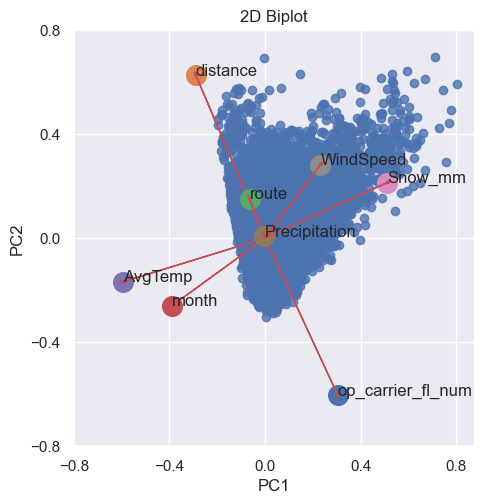

In [150]:
import seaborn as sns
sns.set()
 
xs = loadings[0]
ys = loadings[1]

sns.lmplot(
    x='PC1', 
    y='PC2',
    data=pca_df_scaled, 
    fit_reg=False,
    legend = False
    )


for i, varnames in enumerate(feature_names):
    plt.scatter(xs[i], ys[i], s=200)
    plt.arrow(
        0, 0, # coordinates of arrow base
        xs[i], # length of the arrow along x
        ys[i], # length of the arrow along y
        color='r', 
        head_width=0.01
        )
    plt.text(xs[i], ys[i], varnames)
 
xticks = np.linspace(-0.8, 0.8, num=5)
yticks = np.linspace(-0.8, 0.8, num=5)
plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('PC1')
plt.ylabel('PC2')
 
plt.title('2D Biplot')
plt.show()

## Scree Plot Check

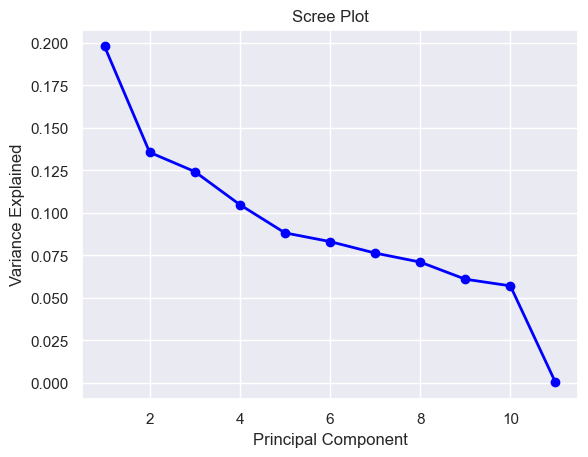

In [62]:
#define PCA model to use
pca = PCA(n_components=11)

#fit PCA model to data
pca_scree_plot = pca.fit_transform(X_scaled)

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

### Modeling

Use different ML techniques to predict each problem.

- linear / logistic / multinomial logistic regression
- Naive Bayes
- Random Forest
- SVM
- XGBoost
- The ensemble of your own choice

### Evaluation

You have data from 2018 and 2019 to develop models. Use different evaluation metrics for each problem and compare the performance of different models.

You are required to predict delays on **out of sample** data from **first 7 days (1st-7th) of January 2020** and to share the file with LighthouseLabs. Sample submission can be found in the file **_sample_submission.csv_**

======================================================================
## Stretch Tasks

### Multiclass Classification

The target variables are **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY**. We need to do additional transformations because these variables are not binary but continuos. For each flight that was delayed, we need to have one of these variables as 1 and others 0.

It can happen that we have two types of delays with more than 0 minutes. In this case, take the bigger one as 1 and others as 0.

### Binary Classification

The target variable is **CANCELLED**. The main problem here is going to be huge class imbalance. We have only very little cancelled flights with comparison to all flights. It is important to do the right sampling before training and to choose correct evaluation metrics.